# Data set 6<br>
This dataset included ground ozone level data collected from 1998 to 2004 in the Houston, Galveston, and Brazoria areas. The dataset focused on eight-hour peaks of ozone levels above a certain threshold. This work used data from 1998 to 2001 as the Primary Source.<br>
## Preliminaries<br>
Import and load the uses Python packages and modules:

In [1]:
import sys
import os
# Add the parent directory to sys.path
parent_directory = os.path.abspath(os.path.join(os.getcwd(), '../main/'))
sys.path.insert(0, parent_directory)
import pandas as pd
import numpy as np
import sim_experiments as smexp_dyn
from datetime import date

Load the data set and prepare it:<br>
Load the data set

In [2]:
df = pd.read_csv("../datasets/ds06-onehr.data", delimiter=",")
df = df.replace("?", np.nan)
df[df.columns.values[1:]] = df[df.columns.values[1:]].astype(float)
df.set_index(["Date"], inplace=True)
dfnum = df.select_dtypes([float, int])
X_PS = dfnum.loc[:"1/1/2002", list(dfnum.columns.values[:-2])]
X_NEW = dfnum.loc["1/1/2002":, list(dfnum.columns.values[:-2])]

Exploratory analysis showing time series decomposigion as an additive model where each time instant ($x_i$) is the addition of a trend component ($T_i$), a seasonal component ($S_i$) and an error component ($E_i$)

In [3]:
smexp_dyn.plot_time_components_div(dfnum.loc[:,list(dfnum.columns.values[:-2])], X_PS.iloc[0:360*3,:].index, X_NEW.index, 360, dsname="ds06comb", 
                                   xtxtsize=5, path_figs="../figures/")

'done'

## Primary Source models<br>
Obtain the parameters for the reference batch of data. The function returns a dictionary *ps_dict* with the parameters to compute each one of the drift metrics according to a different ML model and the _indPS_ variable with the indices of the records used for the reference set.

Step [1/6]: Printing the Original Data Set Features =======
Step [1/6]: Starting ...
              WSR0         WSR1         WSR2         WSR3         WSR4  \
count  1416.000000  1422.000000  1421.000000  1422.000000  1422.000000   
mean      1.694068     1.642616     1.597537     1.567159     1.558861   
std       1.316482     1.316585     1.280686     1.244200     1.235615   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.700000     0.600000     0.600000     0.600000     0.600000   
50%       1.400000     1.300000     1.300000     1.300000     1.300000   
75%       2.500000     2.400000     2.300000     2.200000     2.200000   
max       7.500000     7.700000     7.100000     7.300000     7.200000   

              WSR5         WSR6         WSR7         WSR8         WSR9  ...  \
count  1423.000000  1424.000000  1426.000000  1426.000000  1424.000000  ...   
mean      1.576177     1.667556     2.064376     2.571038     2.897402  ...   
std       1

2023-11-21 18:23:52.281190: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "my_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 54)                3888      
                                                                 
 sequential_1 (Sequential)   (None, 71)                3905      
                                                                 
Total params: 7,793
Trainable params: 7,793
Non-trainable params: 0
_________________________________________________________________
Best model - DONE
Data model -  DONE
Permutation test -  DONE
dE-AE summary: 202.854074716568 s.; 640 b.
Step [3/6]: Finished.


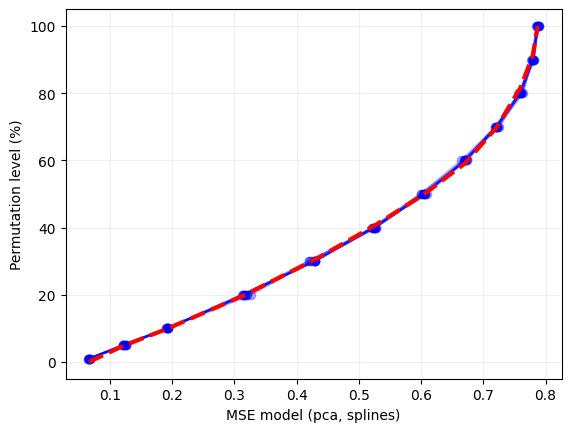

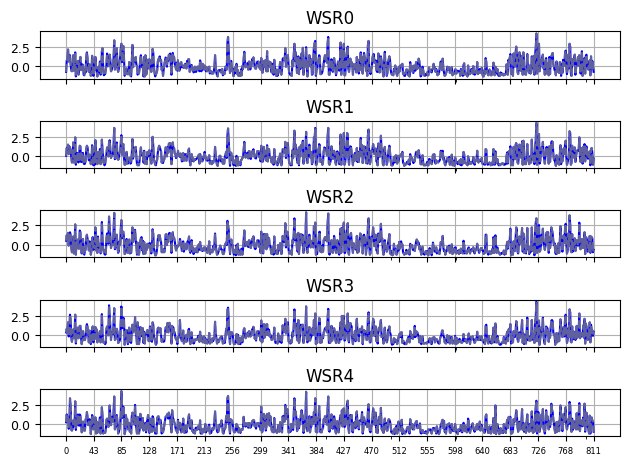

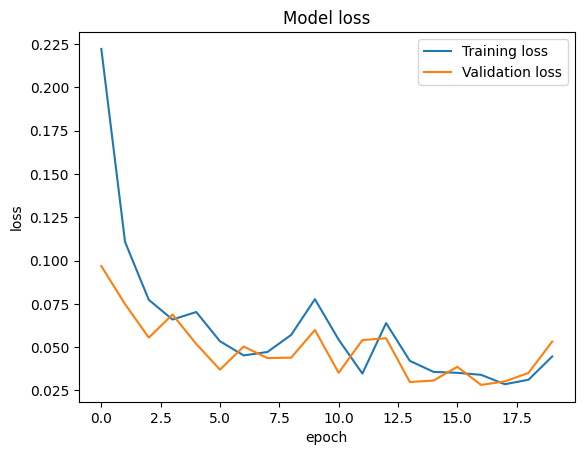

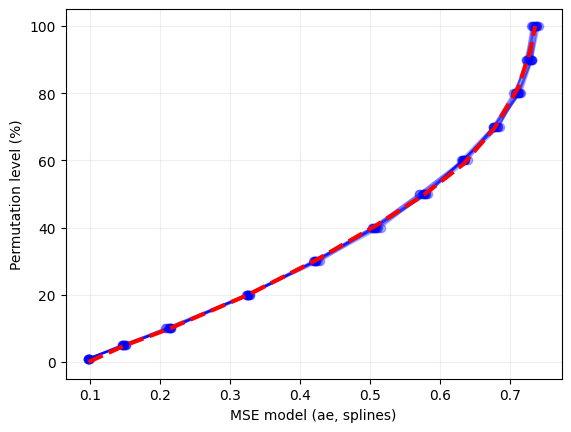

In [4]:
import random
import tensorflow as tf
tf.random.set_seed(42) 
np.random.seed(42)
random.seed(42)
print("Doing Primary Source Model -- \n" + "N = " + str(len(X_PS)) + " (" + str(np.round(len(X_PS)/(len(X_PS) + len(X_NEW))*100,2)) + " %" + " of total dataset length)")
ps_dict, ind_PS = smexp_dyn.get_PS_data(X_PS, resultspath = "../results/ds06/", dstitle = "DS 06 PS", 
                                        PSfilename = "ds06ps.pkl", mse_model_type="splines", pctge_PS=1, tr_val_split=0.7, resultsfile = "/dyn-ds-06")

### New versions<br>
When a new version of the dataset is generated, it will be compared to the information from the previous version in the following way:<br>
  * $d_{P}$: computes the cosine distance between loading matrices obtained for both data sets;<br>
  * $d_{E, PCA}$: computes the MSE obtained by reconstructing the new batch using the reference PCA model. This value is fed into a quadratic model fitted with the reference data set, which relates MSE values to levels of corruption artificially simulated by permuting entries from the reference set.<br>
  * $d_{E, AE}$: computes the MSE obtained by reconstructing the new batch using the reference AE model. This value is fed into a quadratic model fitted with the reference data set, which relates MSE values to levels of corruption artificially simulated by permuting entries from the reference set.<br>


## Creation events<br>
The following experiments use an initial subset as reference and add new batches of different size.

In [5]:
print("  - Case 1: add rows of new set \n")
try:
    smexp_dyn.do_exp(X_NEW, ps_dict, resultspath = "../results/ds06", mode_der = "add_batch", 
                    batchsize_pctges = [0.05, 0.1, 0.25, 0.5, 0.75, 1], dstitle="DS 06 batch addition", resultsfile="/dyn-ds-06-add")
except Exception as e: print(e)

  - Case 1: add rows of new set 

New versions, level 0.05- start
New versions, level 0.05- end
New versions, level 0.1- start
New versions, level 0.1- end
New versions, level 0.25- start
New versions, level 0.25- end
New versions, level 0.5- start
New versions, level 0.5- end
New versions, level 0.75- start
New versions, level 0.75- end
New versions, level 1- start
New versions, level 1- end
DER: done


## Update events<br>

In [6]:
print("  - Case 2.1: transform columns ..\n")
try: 
    smexp_dyn.do_exp(X_PS, ps_dict, resultspath = "../results/ds06", mode_der = "trans_cols",
                    tr_pctges = [0.05, 0.1, 0.3, 0.5, 0.7, 0.8, 1], dstitle="DS 06 cbrt scale", batchsize_pctges=[1], kfolds=1,
                    modetr="cbrt",resultsfile="/fixed-ds-06-trcols-cbrt")
except Exception as e: print(e)

  - Case 2.1: transform columns ..

New versions, level 0.05- start
New versions, level 0.05- end
New versions, level 0.1- start
New versions, level 0.1- end
New versions, level 0.3- start
New versions, level 0.3- end
New versions, level 0.5- start
New versions, level 0.5- end
New versions, level 0.7- start
New versions, level 0.7- end
New versions, level 0.8- start
New versions, level 0.8- end
New versions, level 1- start
New versions, level 1- end
DER: done


## Deletion events<br>
In the following cases, the reference set contains all the records and some of them are deleted in different ways: signals are down sampled, outliers are removed, etc.

In [7]:
print("  - Case 1.2: remove rows decimate .. \n")
try:
    smexp_dyn.do_exp(X_PS, ps_dict, resultspath = "../results/ds06", mode_der = "rem_rows_decimate", 
                     tr_pctges = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05], dstitle="DS 06 decimate", batchsize_pctges=[1], resultsfile="/fixed-ds-06-downsample")
except Exception as e: print(e)

  - Case 1.2: remove rows decimate .. 

New versions, level 0.5- start
New versions, level 0.5- end
New versions, level 0.4- start
New versions, level 0.4- end
New versions, level 0.3- start
New versions, level 0.3- end
New versions, level 0.2- start
New versions, level 0.2- end
New versions, level 0.1- start
New versions, level 0.1- end
New versions, level 0.05- start
New versions, level 0.05- end
DER: done
